<a href="https://colab.research.google.com/github/swathi156/swathi156/blob/main/Depression_Risk_Prediction_Using_LSTM_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jan 29 17:07:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 23.4MB/s]


In [3]:
!unzip -qq ECG5000.zip


In [4]:
!pip install -qq arff2pandas

ERROR: Could not find a version that satisfies the requirement arff2pandas (from versions: none)
ERROR: No matching distribution found for arff2pandas


In [5]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00


In [6]:
!pip install -qq -U pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 49.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.


In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy      : 1.26.4
pandas     : 2.2.3
torch      : 2.5.1+cu121
arff2pandas: not installed



In [11]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

from scipy.io import arff
import torch.nn.functional as F



%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [9]:
!pip install scipy pandas



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from scipy.io import arff
import pandas as pd

# Load the ARFF file using scipy
with open('ECG5000_TRAIN.arff', 'r') as f:
    data, meta = arff.loadarff(f)

# Convert to Pandas DataFrame
train = pd.DataFrame(data)

# Decode byte strings if necessary
train = train.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Display the first few rows
print(train.head())


       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.2

<ipython-input-14-77e652f3baf9>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train = train.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)


In [15]:
from scipy.io import arff
import pandas as pd

# Load the ARFF file using scipy
with open('ECG5000_TEST.arff', 'r') as f:
    data, meta = arff.loadarff(f)

# Convert to Pandas DataFrame
test = pd.DataFrame(data)

# Decode byte strings if necessary
test = test.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Display the first few rows
print(test.head())


       att1      att2      att3      att4      att5      att6      att7  \
0  3.690844  0.711414 -2.114091 -4.141007 -4.574472 -3.431909 -1.950791   
1 -1.348132 -3.996038 -4.226750 -4.251187 -3.477953 -2.228422 -1.808488   
2  1.024295 -0.590314 -1.916949 -2.806989 -3.527905 -3.638675 -2.779767   
3  0.545657 -1.014383 -2.316698 -3.634040 -4.196857 -3.758093 -3.194444   
4  0.661133 -1.552471 -3.124641 -4.313351 -4.017042 -3.005993 -1.832411   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.107067 -0.632322  0.334577  ...  0.022847  0.188937  0.480932  0.629250   
1 -1.534242 -0.779861 -0.397999  ...  1.570938  1.591394  1.549193  1.193077   
2 -2.019031 -1.980754 -1.440680  ...  0.443502  0.827582  1.237007  1.235121   
3 -2.221764 -1.588554 -1.202146  ...  0.777530  1.119240  0.902984  0.554098   
4 -1.503886 -1.071705 -0.521316  ...  1.280823  1.494315  1.618764  1.447449   

     att136    att137    att138    att139    att140  target  
0  0.5

<ipython-input-15-b95289dccd51>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test = test.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)


In [17]:
# Combine train and test DataFrames
df = pd.concat([train, test], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1.0, random_state=42)  # Set random_state for reproducibility

# Check the shape
print(df.shape)


(5000, 141)


In [18]:
CLASS_NORMAL = 1
CLASS_PVC = 2
class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

#DATA PREPROCESSING


In [19]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [20]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1501,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2586,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2653,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
1055,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
705,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


#EXPLORATION OF DATASET

In [21]:
df.target.value_counts()

,count
target,
1,2919
2,1767
4,194
3,96
5,24


<ipython-input-22-a4b264be8d90>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names);


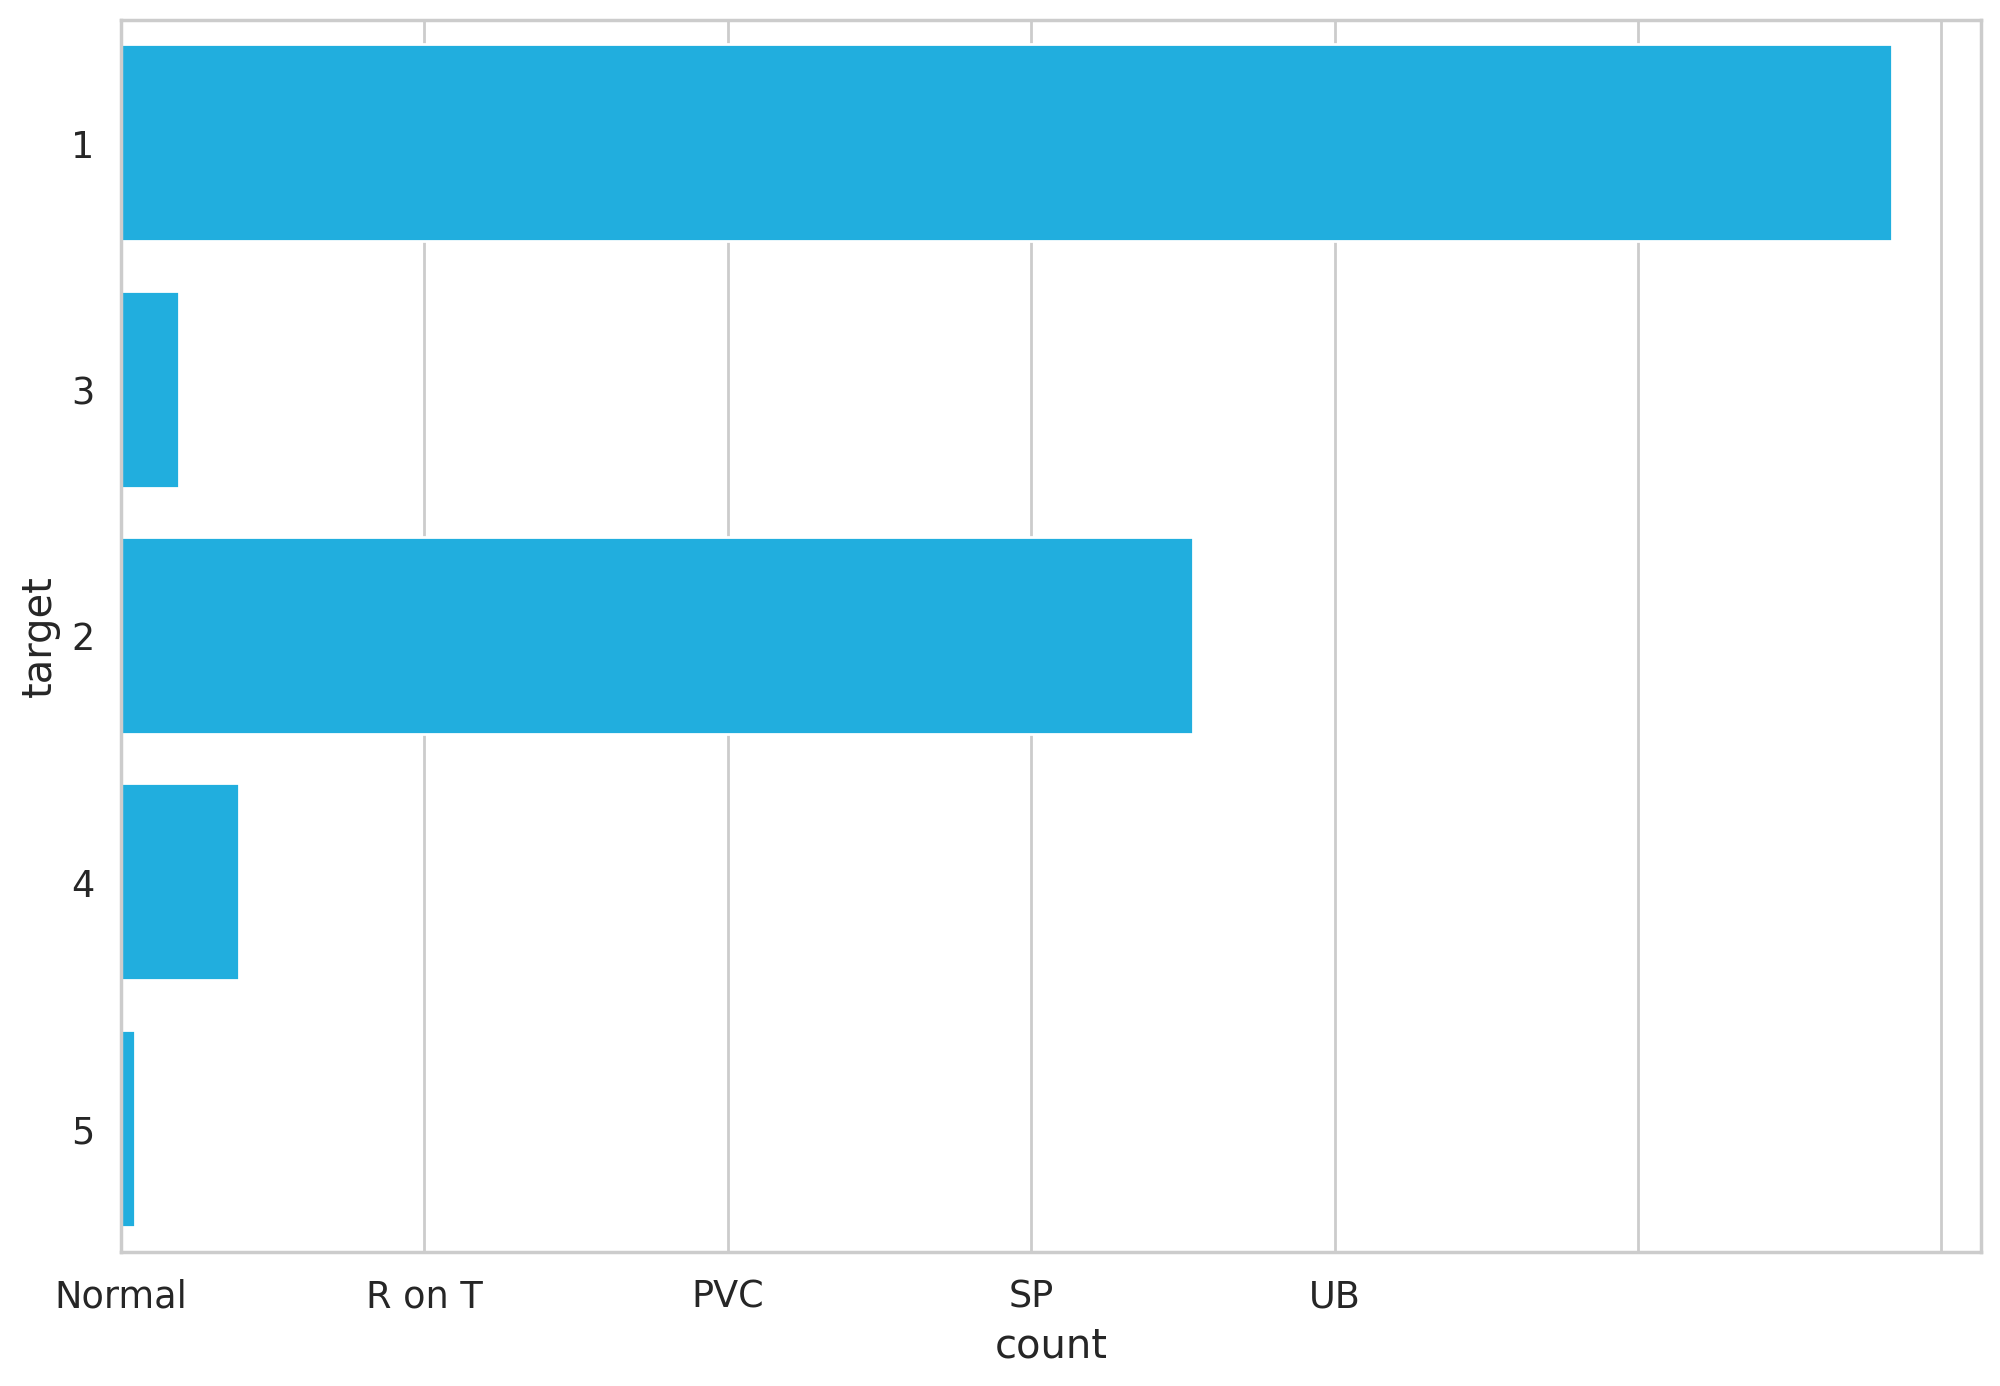

In [22]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

##Time-Series Graph for each Class

In [23]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation) [0]
  over_line = (smooth_path + path_deviation) [0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=.125
  )
  ax.set_title(class_name)

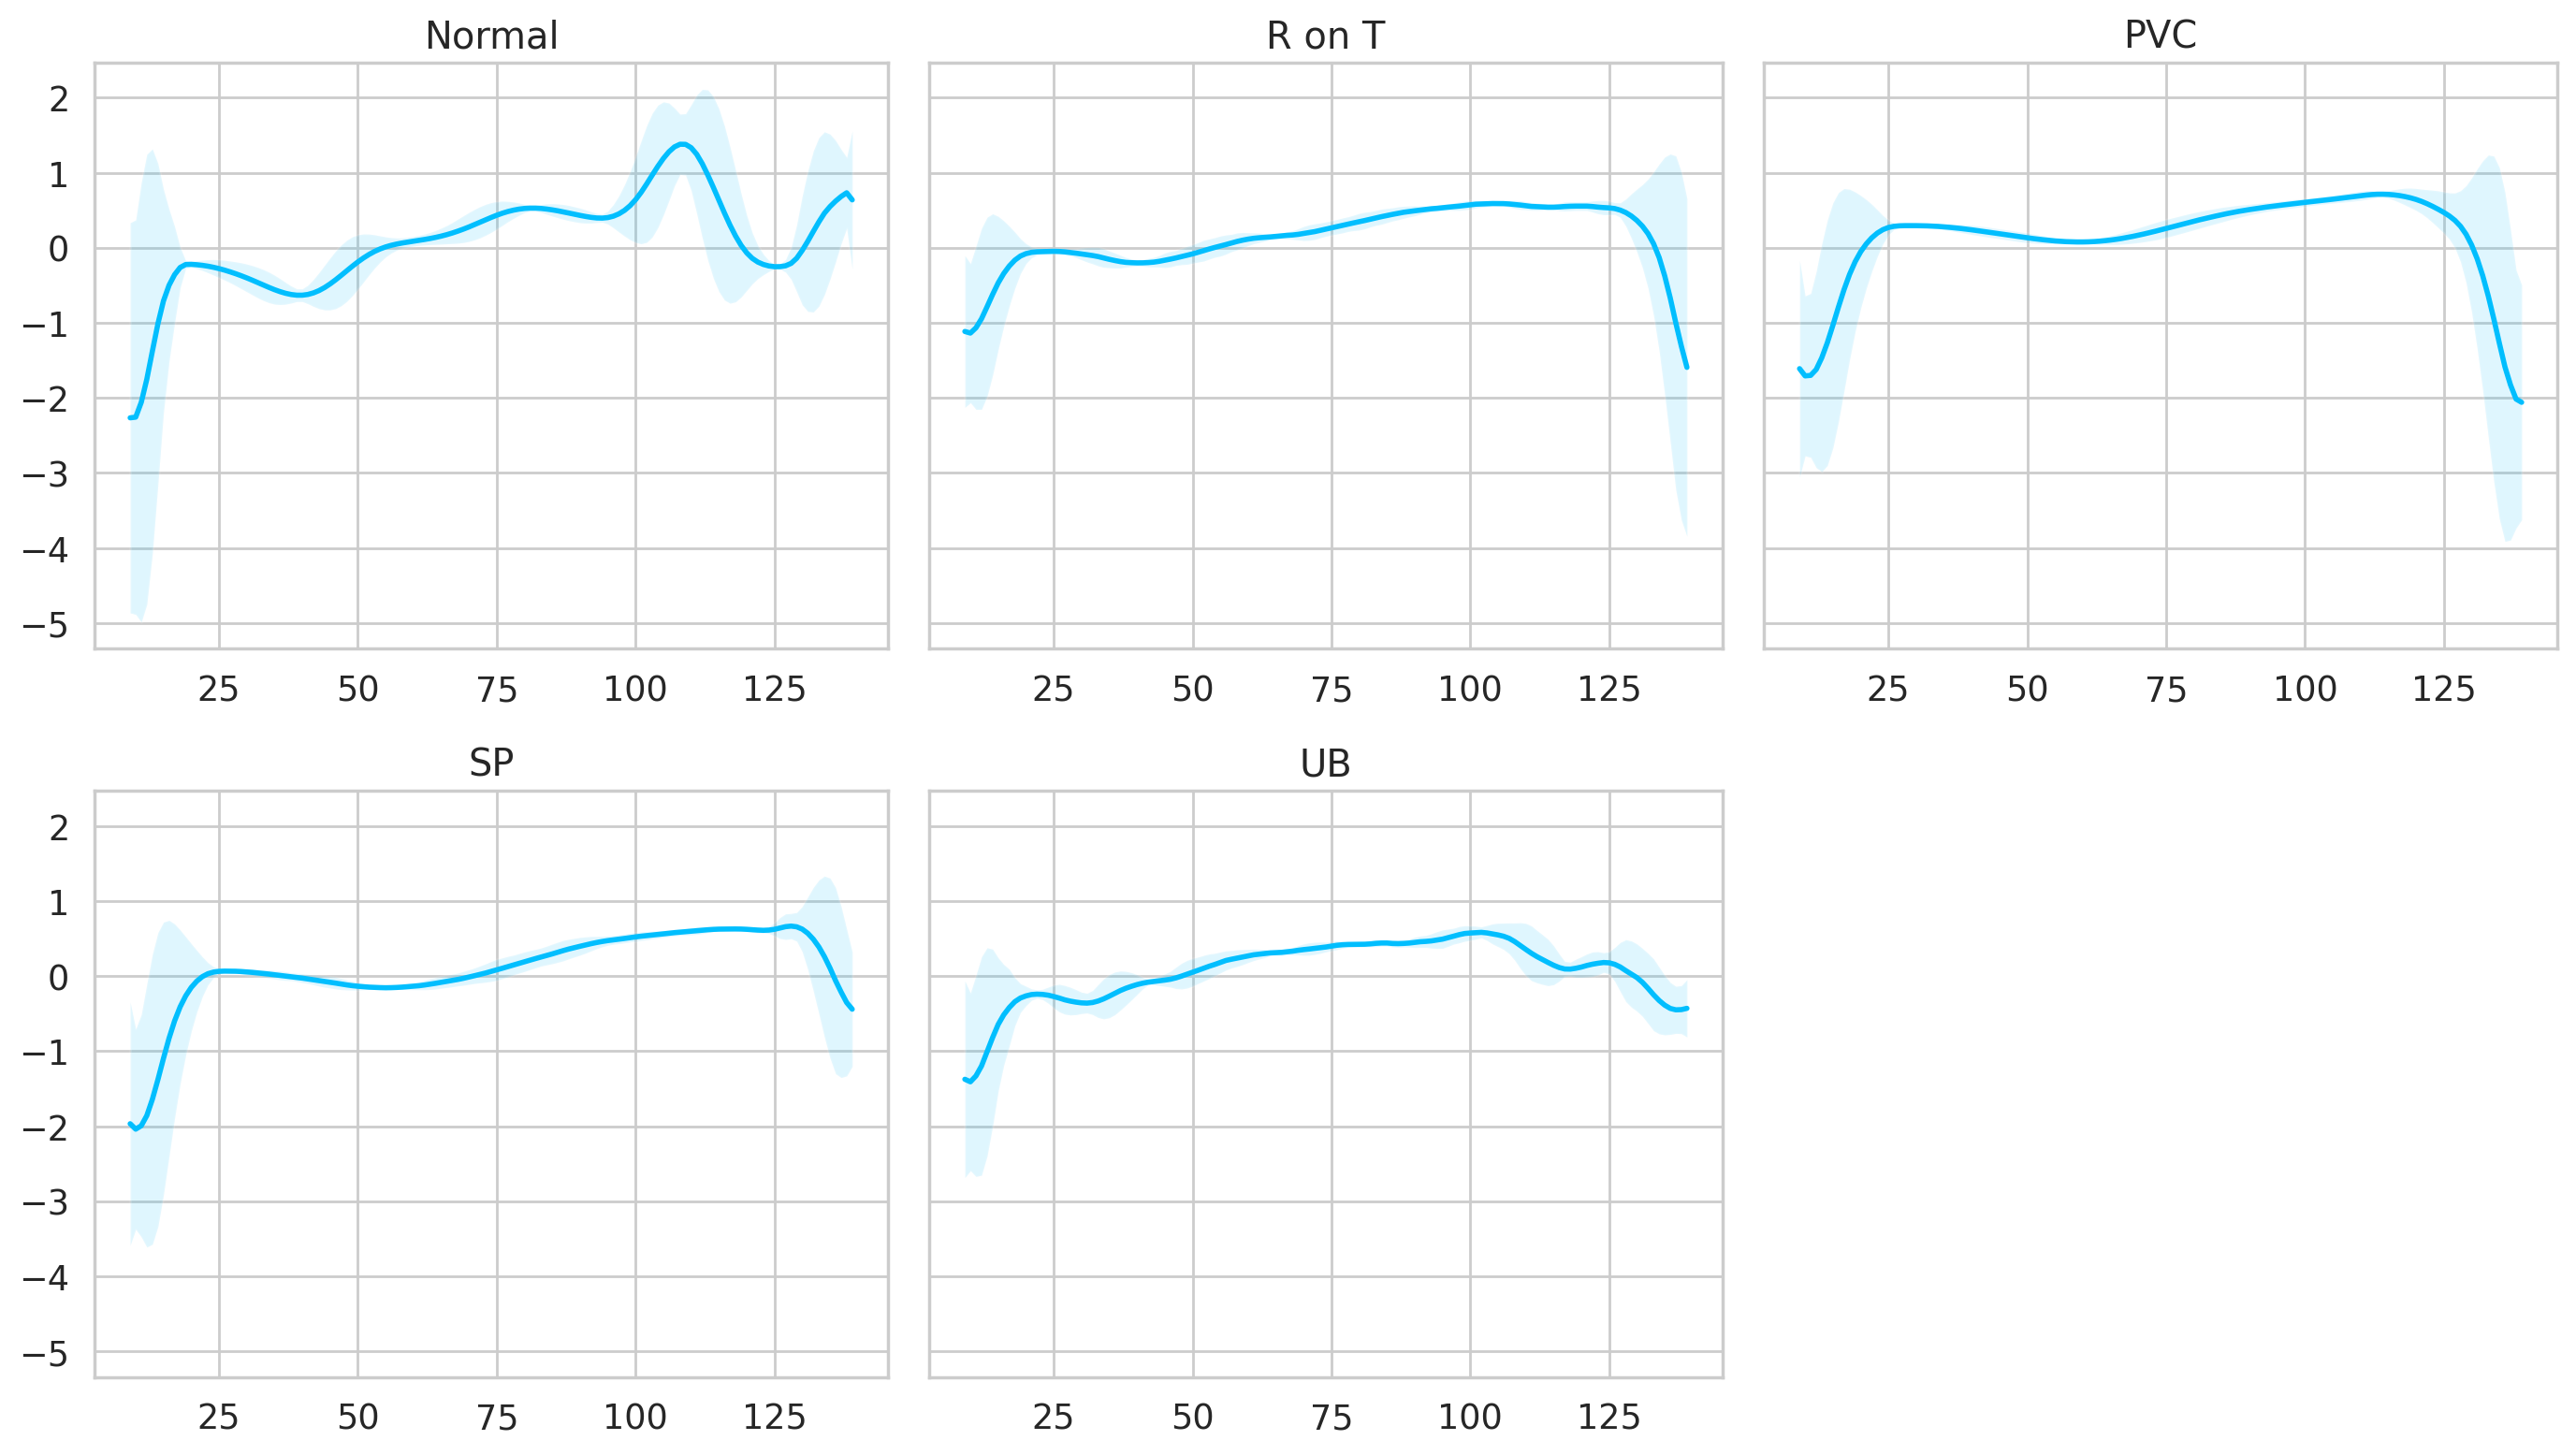

In [24]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [25]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [26]:
abnormal_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
abnormal_df.shape

(2081, 140)

In [27]:
pvc_df = df[df.target == str(CLASS_PVC)].drop(labels='target', axis=1)
pvc_df.shape

(1767, 140)

In [28]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

In [29]:
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [30]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [31]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_abnormal_dataset, _, _ = create_dataset(abnormal_df)
test_pvc_dataset, _, _ = create_dataset(pvc_df)

##AUTOENCODER

In [32]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn3 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [33]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn3 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [34]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [35]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

#TRAINING

In [36]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)


    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 64.25296535745642 val loss 55.162671463481395
Epoch 2: train loss 50.84942158841645 val loss 47.24904332470162
Epoch 3: train loss 42.2971780962254 val loss 44.314948254477855
Epoch 4: train loss 32.9495735771951 val loss 29.65257698033043
Epoch 5: train loss 29.396815699754537 val loss 27.207355320250215
Epoch 6: train loss 26.939092016469946 val loss 27.505139266264724
Epoch 7: train loss 26.010303593412228 val loss 21.894537424471597
Epoch 8: train loss 24.74921117834101 val loss 25.373977869443927
Epoch 9: train loss 23.613160933279694 val loss 23.629723789748883
Epoch 10: train loss 21.90139637431614 val loss 19.64215161775973
Epoch 11: train loss 20.712101709933975 val loss 21.70683555472833
Epoch 12: train loss 20.192757702604123 val loss 22.070442313627172
Epoch 13: train loss 19.901130471773467 val loss 20.555302538562554
Epoch 14: train loss 19.58957201778192 val loss 20.22579302478569
Epoch 15: train loss 18.804941036681022 val loss 23.95473828494752
Epoc

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A

Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
3.98MB [00:00, 63.0MB/s]


In [ ]:
#model = torch.load('model.pth')
#model = model.to(device)

#Choosing Threshold
###Checking the Accuracy

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


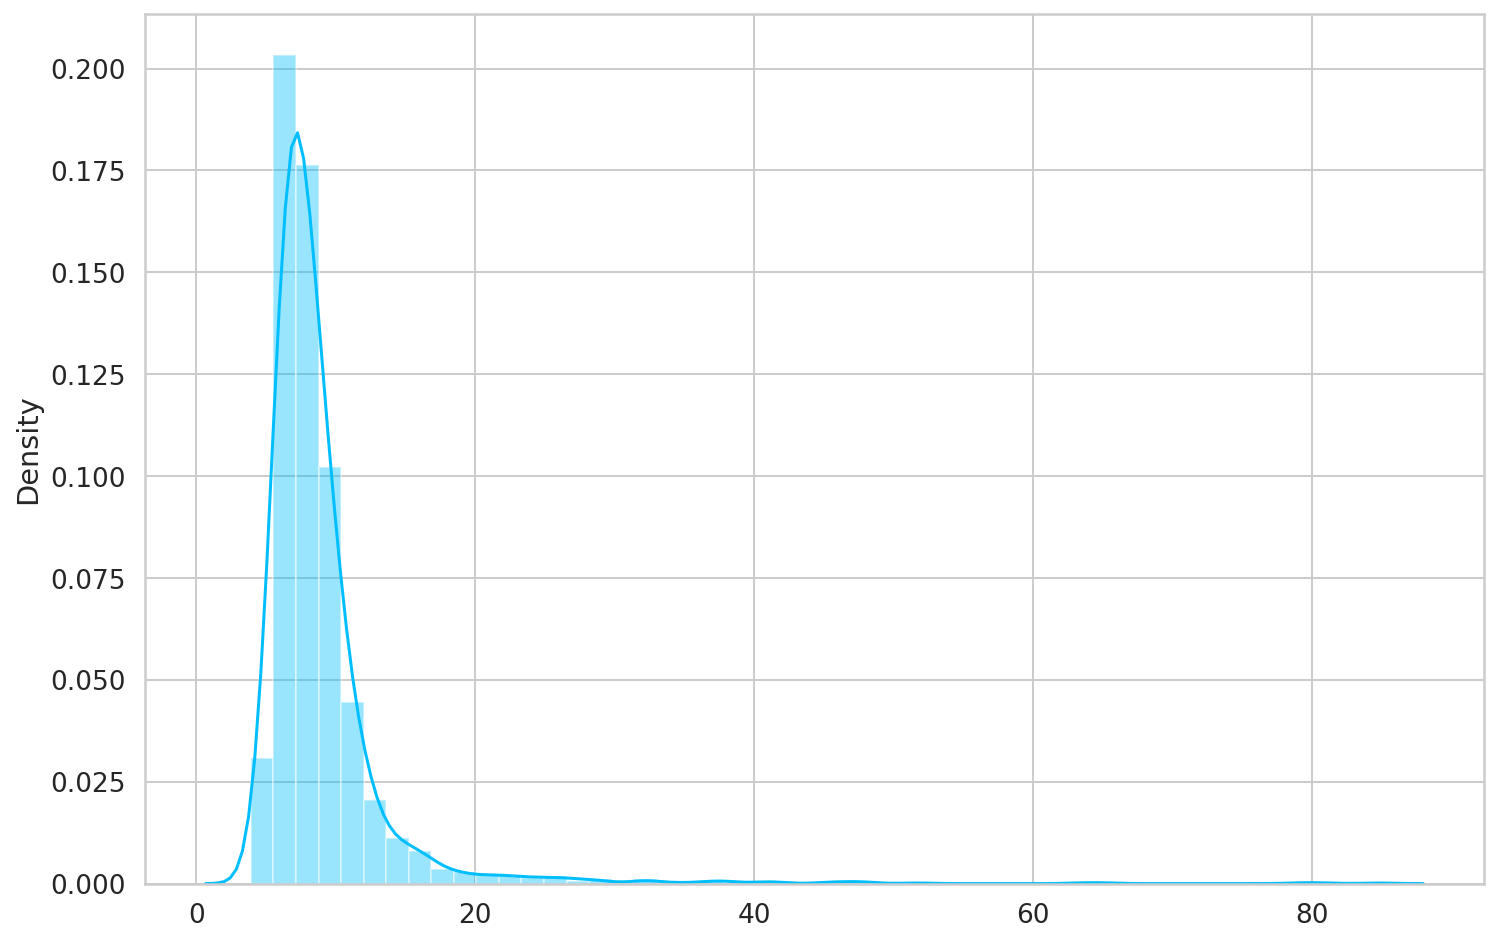

In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 30

#For Normal Heartbeat Prediction

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


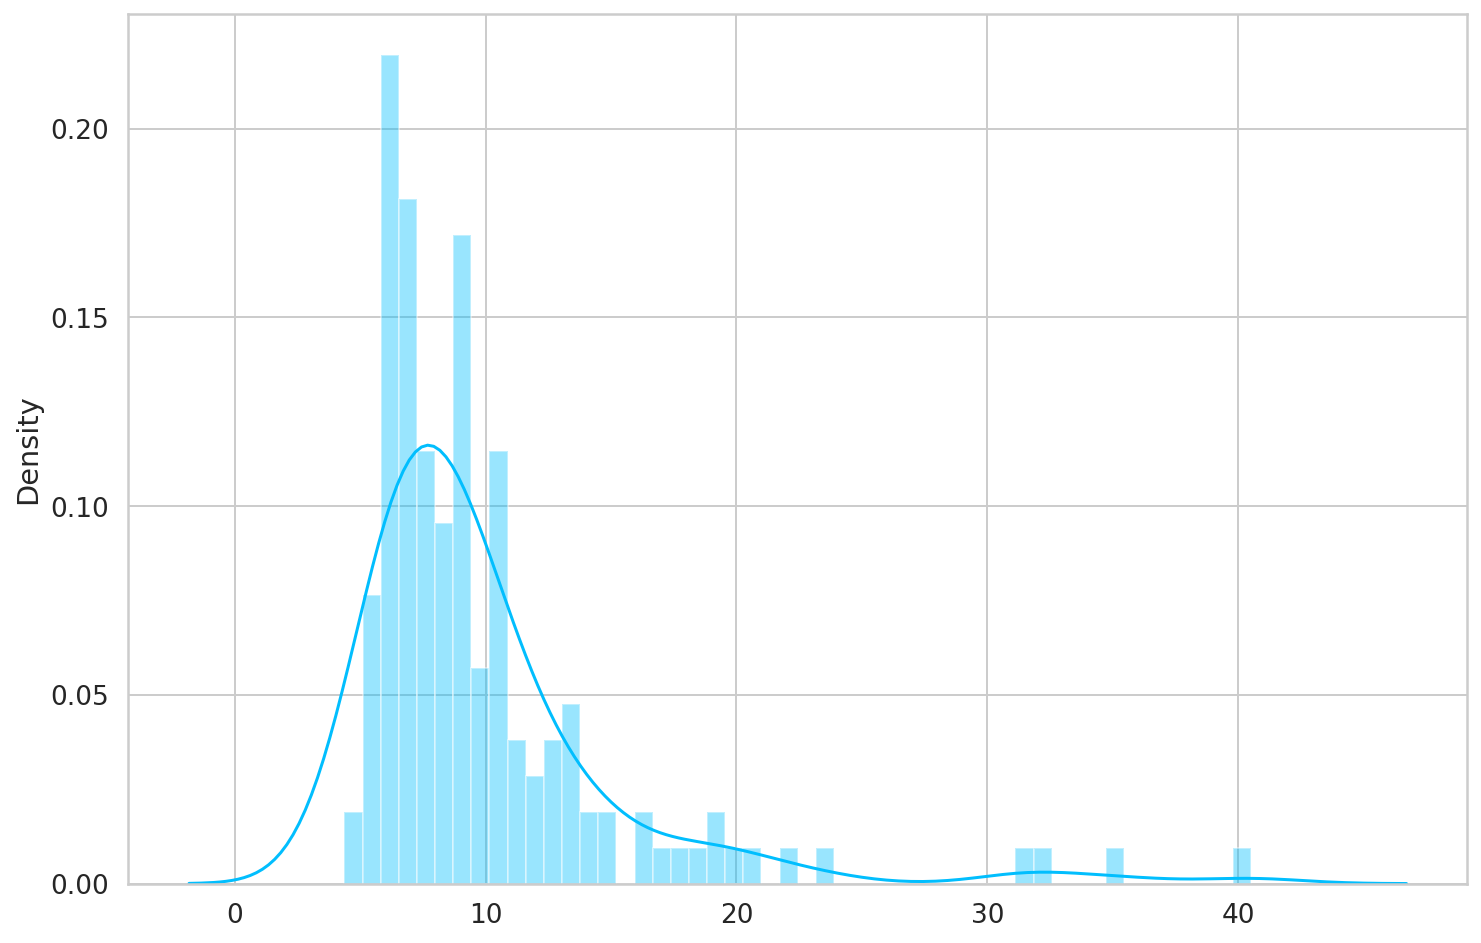

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 141/145


##For Risky Heartbeat Prediction

In [ ]:
pvc_dataset = test_pvc_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, pvc_dataset)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


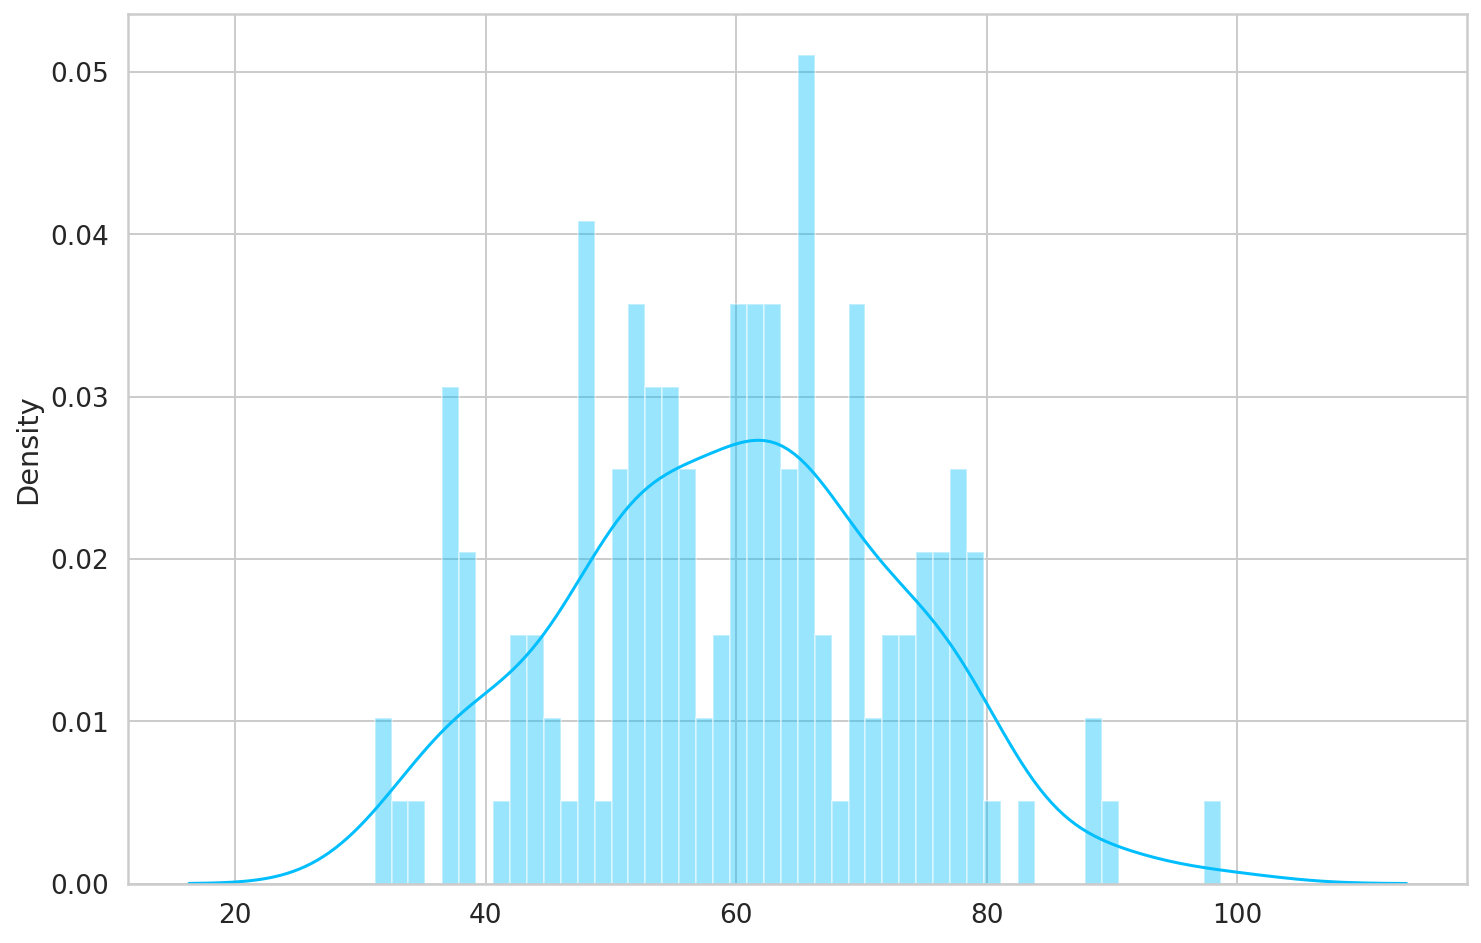

In [ ]:
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct pvc predictions: {correct}/{len(pvc_dataset)}')

Correct pvc predictions: 145/145


#Time Series Prediction: Normal vs Risky

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

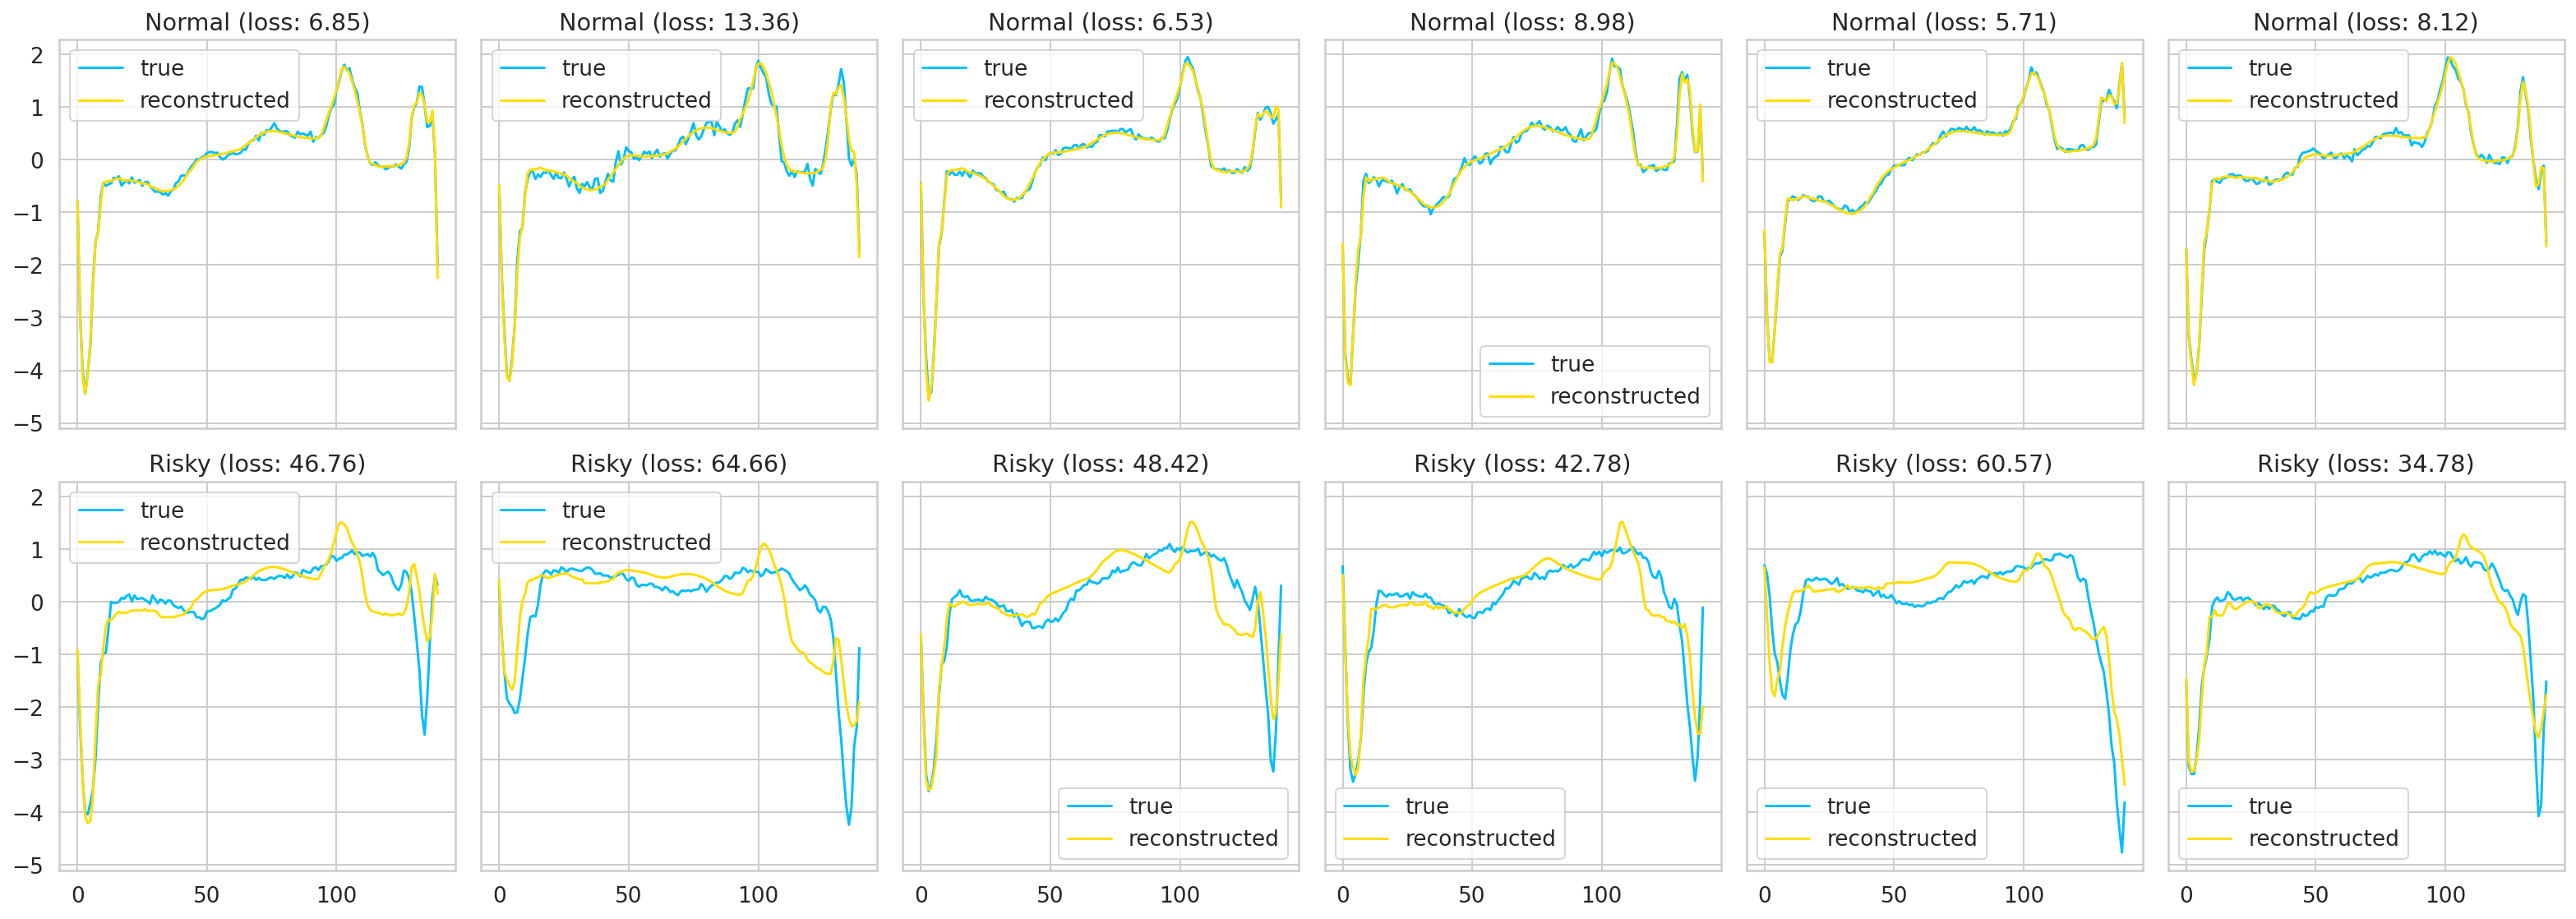

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_pvc_dataset[:6]):
  plot_prediction(data, model, title='Risky', ax=axs[1, i])

fig.tight_layout();

#Time Series Prediction: Abnormal vs Risky

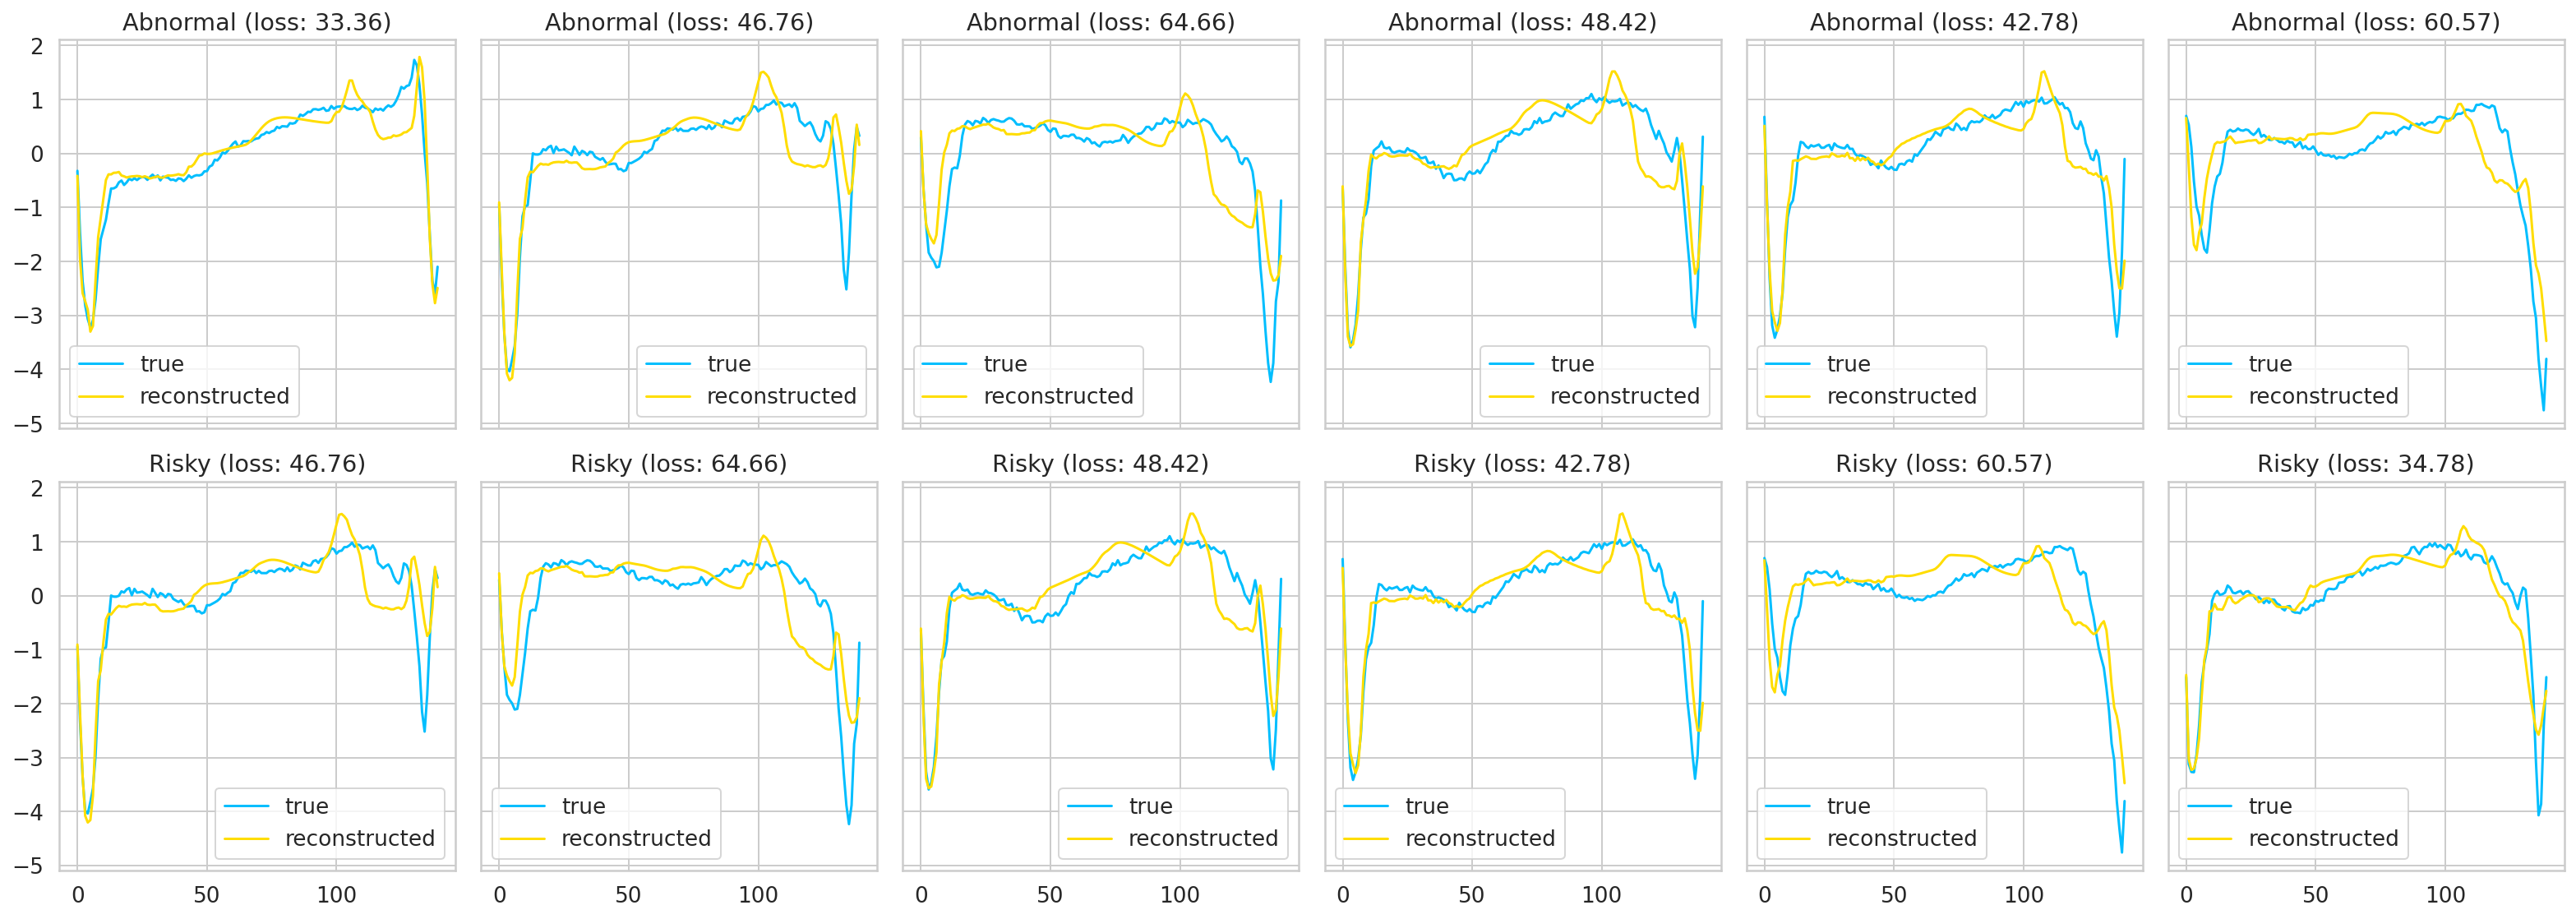

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_abnormal_dataset[:6]):
  plot_prediction(data, model, title='Abnormal', ax=axs[0, i])

for i, data in enumerate(test_pvc_dataset[:6]):
  plot_prediction(data, model, title='Risky', ax=axs[1, i])

fig.tight_layout();